<a href="https://colab.research.google.com/github/anshupandey/Computer-Vision/blob/master/Object_localization_using_Transfer_Learning_PASCAL_VOC_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget -q http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar

In [2]:
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null; echo " done."

 done.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models,layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
import os

In [13]:
df = pd.read_pickle("/content/lrg.csv")
df.head()

,fn,cat,cat_id,bb_coords
0,000012.jpg,car,7,"[96, 155, 269, 350]"
1,000017.jpg,horse,13,"[77, 89, 335, 402]"
2,000023.jpg,person,15,"[1, 2, 461, 242]"
3,000026.jpg,car,7,"[124, 89, 211, 336]"
4,000032.jpg,aeroplane,1,"[77, 103, 182, 374]"


In [14]:
sorted(df.cat_id.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [15]:
df.cat_id = df.cat_id-1
sorted(df.cat_id.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [0]:
main_folder = "/content/VOCdevkit/VOC2007/JPEGImages"

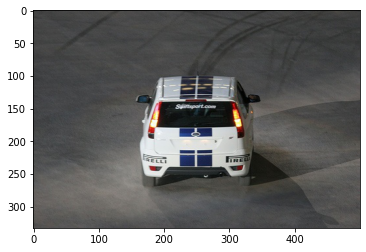

In [17]:
imm = plt.imread(main_folder + "/" + df.fn[0])
plt.imshow(imm)
plt.show()

In [18]:
df.bb_coords[0]

array([ 96, 155, 269, 350])

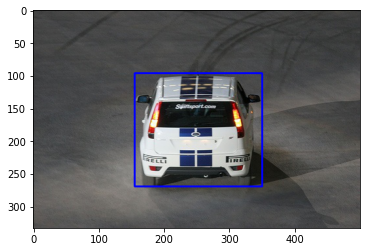

In [20]:
import cv2
cv2.rectangle(imm,(155,96),(350,269),[0,0,255],2)
plt.imshow(imm)
plt.show()

In [0]:
from imgaug import augmenters as ag
import imgaug as ig

In [0]:
def augment(img,bb):
  bb_old = ig.BoundingBoxesOnImage([ig.BoundingBox(x1=bb[1],y1=bb[0],x2=bb[3],y2=bb[2])],shape=img.shape)
  aug1 = ag.Resize({"height": 150, "width": 150}).to_deterministic()
  img_ag = aug1.augment_images([img])[0]
  bb_ag = aug1.augment_bounding_boxes([bb_old])[0]
  bb_out = [bb_ag.bounding_boxes[0].x1,bb_ag.bounding_boxes[0].y1,bb_ag.bounding_boxes[0].x2,bb_ag.bounding_boxes[0].y2]
  return img_ag,bb_out

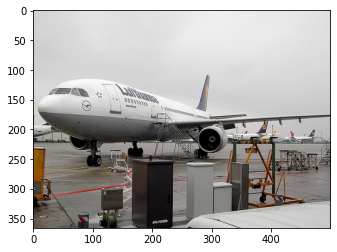

[106   8 262 498]


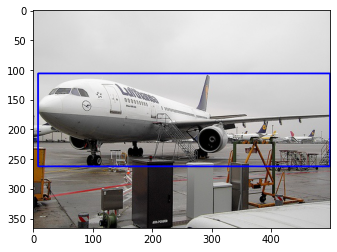

In [47]:
#original 
img = plt.imread(main_folder + "/" + df.fn[5])
plt.imshow(img)
plt.show()
cord = df.bb_coords[5]
print(cord)
img2 = img.copy()
cv2.rectangle(img2,(cord[1],cord[0]),(cord[3],cord[2]),[0,0,255],2)
plt.imshow(img2)
plt.show()

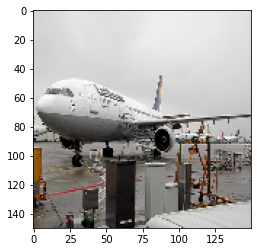

[2.4, 43.442623, 149.4, 107.37705]


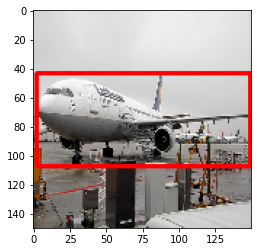

In [48]:
img3,bb3 = augment(img,cord)
plt.imshow(img3)
plt.show()
print(bb3)
cv2.rectangle(img3,(bb3[0],bb3[1]),(bb3[2],bb3[3]),[255,0,0],2)
plt.imshow(img3)
plt.show()

# Dataset preparation

In [0]:
os.listdir(main_folder)[:5]

In [0]:
df.info()

In [0]:
x = [] # for all images
y1 = [] # for all categories
y2 = [] # for bounding boxes


for i in range(df.shape[0]):
  fpath = main_folder + "/" + df.fn[i]
  img = image.load_img(fpath)
  img = image.img_to_array(img)
  img,bb = augment(img,df.bb_coords[i])
  img = resnet50.preprocess_input(img)
  x.append(img)
  y1.append(df.cat_id[i])
  y2.append(bb)

In [53]:
x = np.array(x)
y1 = to_categorical(y1)
y2 = np.array(y2)
print(x.shape)
print(y1.shape)
print(y2.shape)

(2501, 150, 150, 3)
(2501, 20)
(2501, 4)


# Buidling the CNN using Transfer Learning

In [54]:
input_layer = layers.Input(shape=(150,150,3))

model = resnet50.ResNet50(include_top=False,weights='imagenet',input_tensor=input_layer)


for layer in model.layers[:-5]:
  layer.trainable=False


last_layer = model.layers[-1].output

# classification segment
out1 = layers.Flatten()(last_layer)
out1 = layers.Dropout(0.5)(out1)
out1 = layers.Dense(64,activation='relu')(out1)
out1 = layers.Dense(20,activation='softmax',name='classes')(out1)

# regression segment
out2 = layers.Flatten()(last_layer)
out2 = layers.Dropout(0.5)(out2)
out2 = layers.Dense(64,activation='relu')(out2)
out2 = layers.Dense(4,activation='relu',name='bb')(out2)

final_model = models.Model(inputs=input_layer,outputs=[out1,out2])

94773248/94765736 [==============================] - 1s 0us/step


In [55]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [0]:
final_model.compile(optimizer='adam',metrics={"classes":"accuracy"},
                    loss={"bb":"mae","classes":"categorical_crossentropy"},
                    loss_weights={"bb":1,"classes":4})

In [57]:
final_model.fit(x=x,y=[y1,y2],epochs=20,batch_size=64,shuffle=True,validation_split=0.2)

Epoch 1/20
32/32 [==============================] - 4s 121ms/step - loss: 38.0361 - classes_loss: 3.4006 - bb_loss: 24.4336 - classes_accuracy: 0.3000 - val_loss: 27.5163 - val_classes_loss: 2.0016 - val_bb_loss: 19.5097 - val_classes_accuracy: 0.4990
Epoch 2/20
32/32 [==============================] - 2s 77ms/step - loss: 20.9398 - classes_loss: 1.3636 - bb_loss: 15.4856 - classes_accuracy: 0.6145 - val_loss: 25.6297 - val_classes_loss: 1.5879 - val_bb_loss: 19.2783 - val_classes_accuracy: 0.5908
Epoch 3/20
32/32 [==============================] - 2s 76ms/step - loss: 16.2866 - classes_loss: 0.8430 - bb_loss: 12.9146 - classes_accuracy: 0.7300 - val_loss: 24.9160 - val_classes_loss: 1.5594 - val_bb_loss: 18.6785 - val_classes_accuracy: 0.6108
Epoch 4/20
32/32 [==============================] - 2s 77ms/step - loss: 14.2673 - classes_loss: 0.5880 - bb_loss: 11.9154 - classes_accuracy: 0.8080 - val_loss: 23.9469 - val_classes_loss: 1.4487 - val_bb_loss: 18.1521 - val_classes_accuracy: 0.

In [0]:
!wget -q https://sarahelliottphotography.co.uk/wp-content/uploads/2017/01/autumn-childrens-shoot.jpg
!wget -q https://ak8.picdn.net/shutterstock/videos/30988048/thumb/1.jpg

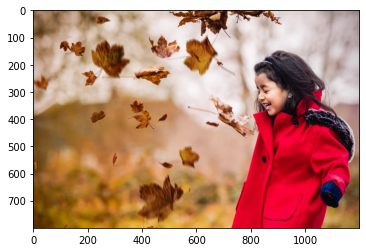

In [59]:
img1 = plt.imread("autumn-childrens-shoot.jpg")
plt.imshow(img1)
plt.show()

In [0]:
img1 = image.load_img("autumn-childrens-shoot.jpg",target_size=(150,150))
img1 = image.img_to_array(img1)
img1 = resnet50.preprocess_input(img1)
output = final_model.predict(img1.reshape(1,150,150,3))

In [61]:
output

[array([[1.5907700e-18, 2.1825134e-15, 3.7034755e-09, 3.9817854e-12,
         2.7616694e-17, 2.6292128e-14, 1.7725396e-09, 2.7110407e-05,
         1.5262500e-10, 2.7507145e-09, 3.8304967e-11, 1.2460988e-12,
         3.9989511e-03, 2.6984995e-16, 9.9597377e-01, 7.8102680e-10,
         1.6508056e-07, 3.3773134e-08, 5.3145176e-15, 1.3778168e-24]],
       dtype=float32),
 array([[ 69.270515,  22.367887, 151.99974 , 150.03088 ]], dtype=float32)]

In [62]:
output_class = np.argmax(output[0])
output_class

14

In [63]:
df.cat[df.cat_id==output_class].unique()

array(['person'], dtype=object)

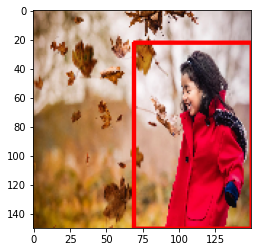

In [65]:
img1 = image.load_img("autumn-childrens-shoot.jpg",target_size=(150,150))
img1 = image.img_to_array(img1).astype('int32')
cv2.rectangle(img1,(69,22),(150,150),[255,0,0],2)
plt.imshow(img1)
plt.show()

In [38]:
img1

array([[[132,  93,  64],
        [155, 116,  87],
        [167, 130, 104],
        ...,
        [152, 136, 136],
        [147, 132, 129],
        [144, 124, 123]],

       [[129,  89,  63],
        [152, 112,  86],
        [167, 130, 104],
        ...,
        [150, 134, 134],
        [152, 134, 134],
        [146, 128, 128]],

       [[128,  89,  60],
        [146, 107,  78],
        [157, 120,  91],
        ...,
        [157, 141, 141],
        [156, 138, 138],
        [156, 138, 138]],

       ...,

       [[ 90,  45,   3],
        [ 90,  49,   3],
        [ 83,  46,   1],
        ...,
        [157, 121,  59],
        [148, 110,  48],
        [139, 101,  39]],

       [[ 92,  48,   1],
        [ 88,  48,   0],
        [ 83,  46,   1],
        ...,
        [157, 118,  53],
        [151, 112,  47],
        [145, 105,  43]],

       [[ 91,  47,   2],
        [ 86,  45,   1],
        [ 87,  49,   2],
        ...,
        [152, 112,  40],
        [152, 113,  44],
        [146, 106,  44]]